Completed iteration 0 with error 6311.958424783521.
Terminated successfully in 9 interations.


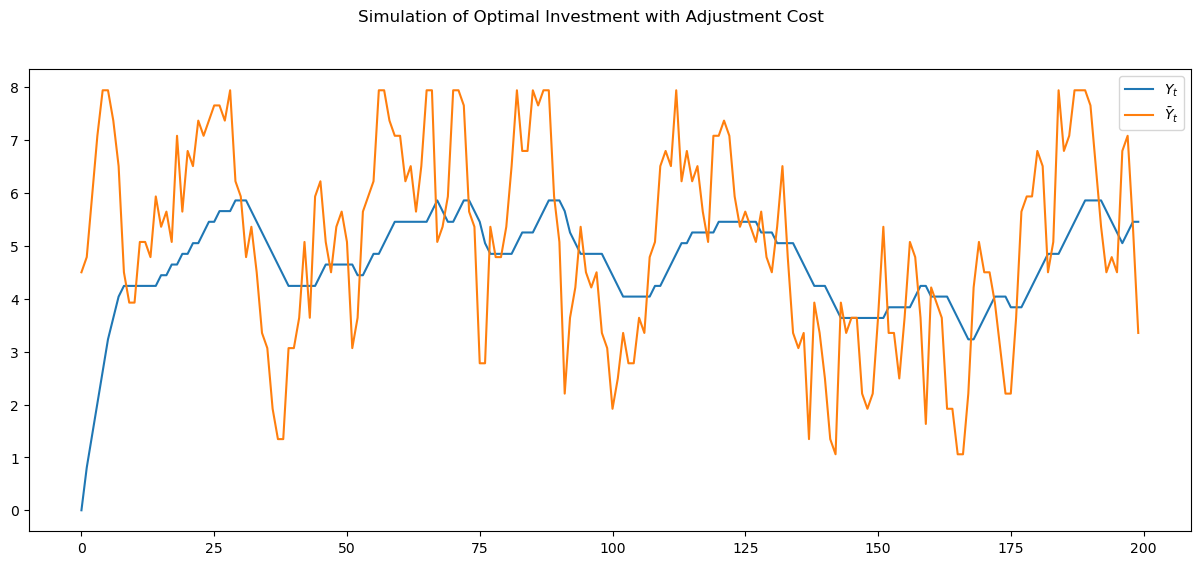

Execution time: 1.1810851097106934 seconds


In [24]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#              DYNAMIC PROGRAMMING BY JOHN STACHURSKI AND THOMAS SARGENT                     #
#                                                                                            #
# This code is used for Chapter 5 Markov DECISION PROCESSES:                                 #
# Application: OPTIMAL INVESTMENT                                                            #
# Improved computation efficiency using numba.njit                                           #
# Written by Longye Tian 16/07/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------------------#
#                               IMPORT LIBRARIES AND PACKAGES                                #
#--------------------------------------------------------------------------------------------#
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from numba import njit                                       
import time
from scipy.sparse.linalg import bicgstab
from scipy.sparse.linalg import LinearOperator
import quantecon as qe

# --------------------------------------------------------------------------------------------#
#                        USE NAMEDTUPLE TO STORE MODEL PARAMETERS                             #
# --------------------------------------------------------------------------------------------#

Optimal_Investment = namedtuple("investment", 
                                ("β",                          # discount rate
                                 "a_0",                        # demand parameter
                                 "a_1",                        # demand parameter
                                 "γ",                          # adjustment cost parameter
                                 "c",                          # unit cost
                                 "Y",                          # Output space
                                 "y_size",                     # Y space size
                                 "z_size",                     # Z space size
                                 "ρ",                          # Tauchen
                                 "ν",                          # Tauchen
                                 "m"                           # Tauchen
                                ))


#---------------------------------------------------------------------------------------------#
#                       CREATE A FUNCTION TO INPUT MODEL PARAMETERS                           #
#---------------------------------------------------------------------------------------------#

def create_optimal_investment_model(r=0.04,
                                    a_0=10.0,
                                    a_1=1.0,
                                    γ=25.0,
                                    c=1.0,
                                    y_min=0.0,
                                    y_max=20.0,
                                    y_size=100,
                                    ρ=0.9,
                                    ν=1.0,
                                    m=3,
                                    z_size=25):
    β = 1/(1+r)
    Y = np.linspace(y_min, y_max, y_size)
    return Optimal_Investment(β=β,
                              a_0=a_0,
                              a_1=a_1,
                              γ=γ,
                              c=c,
                              Y=Y,
                              y_size=y_size,
                              z_size=z_size,
                              ρ=ρ,
                              ν=ν,
                              m=m
                             )


# investment = create_optimal_investment_model()


#---------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                             #
#---------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#---------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                       #
#---------------------------------------------------------------------------------------------#

@njit
def Tauchen(investment):  
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    σ_z = np.sqrt(ν**2/(1-ρ**2))                               # Z's std
    Z = np.linspace(-m*σ_z, m*σ_z, z_size)                     # State space by Tauchen
    s = (Z[z_size-1]-Z[0])/(z_size-1)                          # gap between two states
    Q = np.zeros((z_size,z_size))                              # Initialize Q
    for i in range(z_size):
        Q[i,0] = norm_cdf(Z[0]-ρ*Z[i]+s/2, std=σ_z)            
        Q[i,z_size-1] = 1 - norm_cdf(Z[z_size-1]-ρ*Z[i]-s/2, std=σ_z)   
        for j in range(1,z_size-1):
            Q[i,j] = norm_cdf(Z[j]-ρ*Z[i]+s/2, std=σ_z)-norm_cdf(Z[j]-ρ*Z[i]-s/2, std=σ_z)
    return Z,Q


# investment = create_optimal_investment_model()
# Z,Q = Tauchen(investment)
# np.sum(Q, axis=1)



#--------------------------------------------------------------------------------------------#
#                                   BELLMAN EQUATION FOR V                                   #
#--------------------------------------------------------------------------------------------#

@njit
def B(v, investment):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    Z, Q = Tauchen(investment)

    Y = np.reshape(Y, (y_size, 1, 1))
    Z = np.reshape(Z, (1, z_size, 1))
    YP= np.reshape(Y, (1, 1, y_size))
    r = np.multiply((a_0 - a_1 * Y + Z - c),Y)- γ * np.multiply((YP-Y),(YP-Y))

    v = np.reshape(v, (1, 1, y_size, z_size))
    Q = np.reshape(Q, (1, z_size, 1, z_size))
    EV = np.sum(v*Q, axis=-1)

    return r + β*EV
    
# investment = create_optimal_investment_model()
# v = np.zeros((100, 25))
# v_new = B(v, investment)


#---------------------------------------------------------------------------------------------#
#                                     Greedy Policy                                           #
#---------------------------------------------------------------------------------------------#

@njit
def get_greedy(v, investment):
    return np.argmax(B(v, investment), axis=-1)


#---------------------------------------------------------------------------------------------#
#                                   BELLMAN OPERATOR                                          #
#---------------------------------------------------------------------------------------------#

@njit
def T(v, investment):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    new_B = B(v, investment)
    new_v = np.zeros((y_size, z_size))
    for i in range(y_size):
        for j in range(z_size):
            new_v[i, j] = np.max(new_B[i, j, :])
    return new_v



#---------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                     #
#---------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       investment,                               # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,investment)                                  # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v


#--------------------------------------------------------------------------------------------#
#                                   POLICY OPERATOR                                          #
#--------------------------------------------------------------------------------------------#

def T_σ_vec(v,σ,investment):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    Z,Q = Tauchen(investment)
    Σ = Y[σ]
    Y = np.reshape(Y, (y_size, 1))
    Z = np.reshape(Z, (1, z_size))
    r = np.multiply((a_0 - a_1 * Y + Z - c),Y)- γ * np.multiply((Σ-Y),(Σ-Y))

    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    
    return r + β*EV


#---------------------------------------------------------------------------------------------#
#                           COMPUTE REWARD AND REWARD OPERATOR  --- HPI                       #
#---------------------------------------------------------------------------------------------#

def compute_r_σ(σ, investment):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    Z,Q = Tauchen(investment)

    Σ = Y[σ]
    Y = np.reshape(Y, (y_size, 1))
    Z = np.reshape(Z, (1, z_size))
    r = np.multiply((a_0 - a_1 * Y + Z - c),Y)- γ * np.multiply((Σ-Y),(Σ-Y))
    return r


def R_σ(v, σ, investment):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    Z,Q = Tauchen(investment)
    σ = np.reshape(σ, (y_size, z_size,1))
    V = v[σ]
    Q = np.reshape(Q, (1,z_size,z_size))
    EV = np.sum(V * Q, axis=-1)
    return v - β * EV



#---------------------------------------------------------------------------------------------#
#                                  POLICY EVALUATION --HPI                                    #
#---------------------------------------------------------------------------------------------#

def get_value(σ, investment):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    Z,Q = Tauchen(investment)
    r_σ = compute_r_σ(σ, investment)
    
    x_size = y_size * z_size
    P_σ = np.zeros((y_size,z_size,y_size,z_size))
    for i in np.arange(y_size):
        for j in np.arange(z_size):
            for k in np.arange(z_size):
                P_σ[i,j,σ[i,j],k] = Q[j,k]

    r_σ = np.reshape(r_σ, (x_size,1))
    P_σ = np.reshape(P_σ, (x_size,x_size))
    I = np.eye(x_size)
    v_σ = np.linalg.solve((I-β*P_σ), r_σ)
    v_σ = np.reshape(v_σ, (y_size, z_size))
    
    return v_σ






#---------------------------------------------------------------------------------------------#
#                                      ALGORITHMS                                             #
#---------------------------------------------------------------------------------------------#


#---------------------------------------------------------------------------------------------#
#                                VALUE FUNCTION ITERATION                                     #
#---------------------------------------------------------------------------------------------#

def value_function_iteration(investment):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    v_init = np.zeros((y_size, z_size))
    v_star = successive_approx(T, v_init, investment)
    σ_star = get_greedy(v_star, investment)
    return v_star,  σ_star


# investment = create_optimal_investment_model()
# value_function_iteration(investment)



#---------------------------------------------------------------------------------------------#
#                              OPTIMISTIC POLICY ITERATION                                    #
#---------------------------------------------------------------------------------------------#

# Currently OPI does not converge if we use T_σ (for loops indexing with numba)

# OPI converges if we use T_σ_vec (multi-dimensional indexing without numba)

def optimistic_policy_iteration(investment,
                                M=100,
                                tol=1e-6, 
                                max_iter=10_000,
                                print_step=25):
    
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    v = np.zeros((y_size, z_size))
    error = tol+1
    k = 0 

    while error > tol and k < max_iter:
        last_v = v
        σ = get_greedy(last_v,investment)
        for i in range(M):
            v = T_σ_vec(v, σ, investment)
        error = np.max(np.abs(last_v-v))
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
        v_star_opi = v
        σ_star_opi = get_greedy(v_star_opi, investment)
    else:     
        print("Warning: hit iteration bound.")
    return v_star_opi, σ_star_opi


#---------------------------------------------------------------------------------------------#
#                                HOWARD POLICY ITERATIONS                                     #
#---------------------------------------------------------------------------------------------#

def howard_policy_iteration(investment, 
                            tol=1e-6, 
                            max_iter=10_000, 
                            print_step=25):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    v = np.zeros((y_size, z_size))
    error = 1 + tol
    k=0
    while error > tol and k < max_iter:
        σ = get_greedy(v, investment)
        v_σ = get_value(σ, investment)
        error = np.max(np.abs(v_σ-v))
        v = v_σ
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error <= tol:
        print(f"Terminated successfully in {k} interations.")
        v_star_hpi = v
        σ_star_hpi = get_greedy(v_star_hpi, investment)
    else:
        print("Warning: hit iteration bound.")
    return v_star_hpi, σ_star_hpi




#---------------------------------------------------------------------------------------------#
#                                     SIMULATIONS                                             #
#---------------------------------------------------------------------------------------------#

def simulate_optimal_investment(investment, 
                                y_init = 0.0,
                                ts_length=200, 
                                random_state=0):
    β, a_0, a_1, γ, c, Y, y_size, z_size, ρ, ν, m = investment
    Z,Q = Tauchen(investment)
    v_star_opi, σ_star_opi = optimistic_policy_iteration(investment)
    T = np.arange(ts_length)

    mc = qe.MarkovChain(Q, state_values=Z)
    Z_seq = mc.simulate(ts_length=ts_length, random_state=random_state)
    mc_index = qe.MarkovChain(Q, state_values=np.arange(z_size))
    Z_index_seq = mc_index.simulate(ts_length=ts_length, random_state=random_state)

    Y_seq = np.zeros((ts_length, 1))
    Y_seq[0] = y_init
    for i in np.arange(1, ts_length):
        Y_index = np.where(Y==Y_seq[i-1])[0][0]
        Y_seq[i] = Y[σ_star_opi[Y_index, Z_index_seq[i-1]]]

    Y_bar_seq = np.zeros((ts_length,1))
    Y_bar_seq = (a_0-c+Z_seq)/(2*a_1)

    fig, ax = plt.subplots(figsize=(15, 6))
    fig.suptitle('Simulation of Optimal Investment with Adjustment Cost')
    ax.plot(T,Y_seq, label='$Y_t$')
    ax.plot(T,Y_bar_seq, label=r'$\bar{Y}_t$')
    ax.legend()
    plt.show()






#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


investment = create_optimal_investment_model()
simulate_optimal_investment(investment)


#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")









                            
















Completed iteration 0 with error 6311.958424783521.
Terminated successfully in 9 interations.


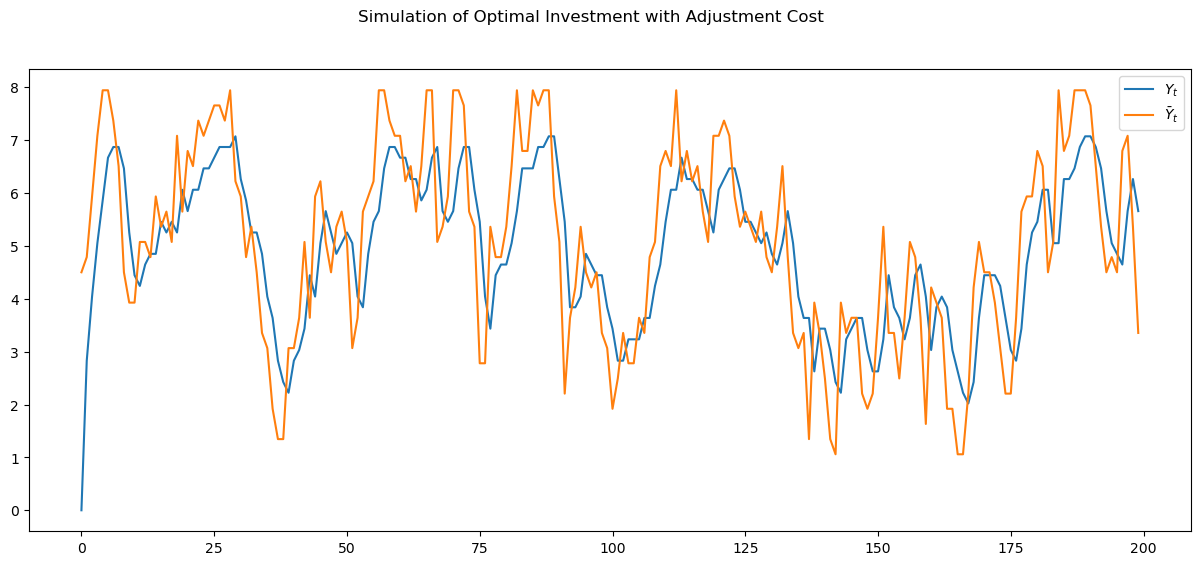

Execution time: 0.2765653133392334 seconds


In [32]:
#---------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                          #
#---------------------------------------------------------------------------------------------#

start_time = time.time()

#-------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


investment = create_optimal_investment_model(γ=1)
simulate_optimal_investment(investment)


#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")